# Check differentiation matrices

In this notebook, we want to verify the differentiation matrices constructed in the `LeafNode` object are working correctly. 

In [1]:
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator
# I have to do this because I'm running the notebook in the checks/ directory
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:

from src.hps.interior_solution import LeafNode
from src.utils import differentiation_matrix_1d, chebyshev_points, points_to_2d_lst_of_points, get_incident_plane_waves

### Set up geometric information about the local grid, as well as a simple scattering object

In [4]:
DOMAIN_MAX = 4.0
N_CHEB_PTS = 50
N_GAUSS_PTS = 50
UPPER_LEFT_X = -DOMAIN_MAX
UPPER_LEFT_Y = DOMAIN_MAX


In [5]:
x = torch.linspace(-DOMAIN_MAX, DOMAIN_MAX, N_CHEB_PTS)
pts_lst = points_to_2d_lst_of_points(x)
radii = torch.linalg.norm(pts_lst, axis=1)

scattering_obj = 1e-04 * (torch.exp(-1 * radii))
obj_for_plt = scattering_obj.numpy().reshape(N_CHEB_PTS, N_CHEB_PTS)

## Set up LeafNode cell

In [6]:
omega_val = 2 * np.pi * 4
l = LeafNode(half_side_len=DOMAIN_MAX, 
             n_cheb_pts=N_CHEB_PTS, 
             n_gauss_pts=N_GAUSS_PTS, 
             upper_left_x=UPPER_LEFT_X, 
             upper_left_y=UPPER_LEFT_Y, 
             omega=omega_val, 
             q=scattering_obj, 
             sample_points=pts_lst)

norm_factor:  1


A few ways to test `l.D_x` and `l.D_y`
 - Constant vector applied to either of these matrices should be 0.
 - Something constant in a single direction should evaluate to 0 for one differentiation matrix, and nonzero for the other matrix.
 - second derivative of $\sin(x)$ is $-\sin(x)$.



## Constant vector


In [7]:
# Make a constant vector u
u = torch.ones(N_CHEB_PTS**2).to(torch.float64)
print(u.dtype)
print(l.D_x.dtype)

# Compute D_x u
D_x_u = l.D_x @ u

# Compute D_y u
D_y_u = l.D_y @ u

torch.float64
torch.float64


In [8]:
print(torch.linalg.norm(D_x_u))
print(torch.linalg.norm(D_y_u))

tensor(1.3331e-10, dtype=torch.float64)
tensor(9.4827e-11, dtype=torch.float64)


## Constant in x, y


In [9]:
# Make this sin_const so that the evaluations have 1 period no matter the domain size
# sin_const = np.pi / DOMAIN_MAX
sin_const = 1
def const_in_x(pts_lst: torch.Tensor) -> torch.Tensor:
    """pts_lst has shape (N, 2).
    Output has shape (N,)
    """
    return torch.sin( sin_const * pts_lst[:, 1])

def const_in_y(pts_lst: torch.Tensor) -> torch.Tensor:
    """pts_lst has shape (N, 2).
    Output has shape (N,)
    """
    return torch.sin(sin_const * pts_lst[:, 0])
    

In [10]:
v_const_in_x = const_in_x(l.cheby_quad_obj.points_lst).to(torch.float64)
v_const_in_y = const_in_y(l.cheby_quad_obj.points_lst).to(torch.float64)


# Compute D_x v_const_in_x
out_0 = l.D_x @ v_const_in_x / (sin_const) ** 2
out_1 = l.D_y @ v_const_in_x / (sin_const) ** 2



In [11]:
print(torch.linalg.norm(out_0))
print(torch.linalg.norm(out_1))


tensor(8.5159e-11, dtype=torch.float64)
tensor(32.3012, dtype=torch.float64)


In [12]:
out_2 = l.D_x @ v_const_in_y / (sin_const) ** 2
out_3 = l.D_y @ v_const_in_y / (sin_const) ** 2
print(torch.linalg.norm(out_2))
print(torch.linalg.norm(out_3))


tensor(32.3012, dtype=torch.float64)
tensor(7.4594e-11, dtype=torch.float64)


In [13]:
# Out_2 should be  -1 * v_cosnt_in_y
print(torch.linalg.norm(out_2 + v_const_in_y))

# Out_1 should be -1 * v_const_in_x
print(torch.linalg.norm(out_1 + v_const_in_x))

tensor(1.2827e-10, dtype=torch.float64)
tensor(8.9715e-11, dtype=torch.float64)


In [14]:
v_const_in_x_reg = l.cheby_quad_obj.interp_from_2d_points(pts_lst, v_const_in_x)

out_1_reg = l.cheby_quad_obj.interp_from_2d_points(pts_lst, out_1)

torch.Size([50, 50])


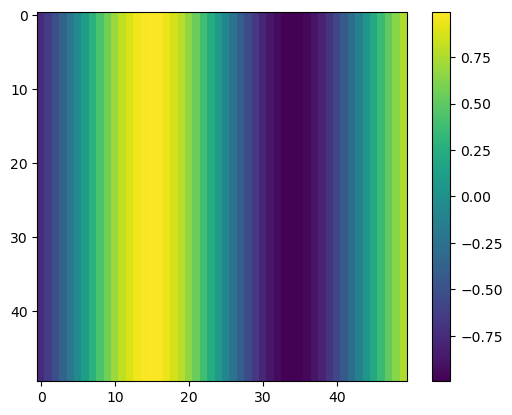

In [15]:
print(v_const_in_x_reg.shape)

plt.imshow(v_const_in_x_reg.numpy().reshape(N_CHEB_PTS, N_CHEB_PTS))
plt.colorbar()

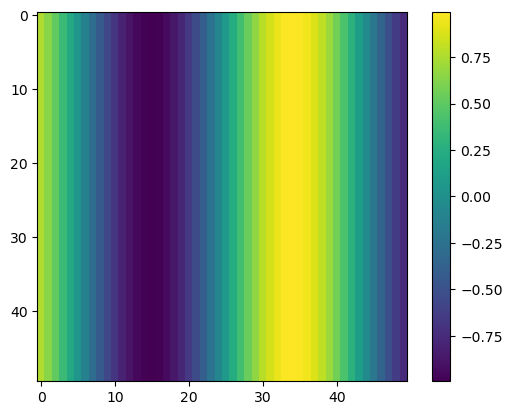

In [16]:
plt.imshow(out_1_reg.numpy().reshape(N_CHEB_PTS, N_CHEB_PTS))
plt.colorbar()

In [17]:
out_4 = l.D_y_single @ v_const_in_x

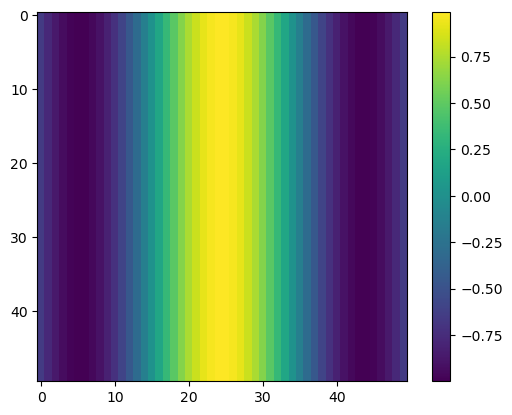

In [18]:
out_4_reg = l.cheby_quad_obj.interp_from_2d_points(pts_lst, out_4)

plt.imshow(out_4_reg.numpy().reshape(N_CHEB_PTS, N_CHEB_PTS))
plt.colorbar()
plt.show()